In [4]:
import numpy as np
import pandas as pd
import json
from collections import Counter
from PIL import Image
import os
import json
import matplotlib.pyplot as plt
import random
import cv2
import numpy as np
import pandas as pd


In [38]:
with open('./test_before.json') as f:
    before_data = json.load(f)
    f.close()
    
with open('./test_before_after.json') as f:
    after_data = json.load(f)
    f.close()

In [46]:
befores = []
for i in before_data:
    if 'before' in before_data[i]:
        if len(before_data[i]['before']) > 0:
            befores.append(before_data[i]['before'])

In [44]:
afters = []
for i in after_data:
    if 'after' in after_data[i]:
        afters.append(after_data[i]['after'])

In [49]:
print(len(befores))
print(len(afters))

8894
1407


In [50]:
afters_sen_lens = [len(i[0].split(' ')) for i in afters if len(i) > 0]
befores_sen_lens = [len(i[0].split(' ')) for i in befores if len(i) > 0]

In [71]:
befores_text = Counter(' '.join(sum(befores, [])).split(' '))
total_b = sum(befores_text.values())

In [72]:
afters_text = Counter(' '.join(sum(afters, [])).split(' '))
total_a = sum(afters_text.values())

In [80]:
print(total_b)
print(total_a)

89091
32772


In [82]:
print(len(befores_text)/89091)
print(len(afters_text)/32772)

0.010618356511881111
0.01794214573416331


In [61]:
len(afters_text)

588

In [51]:
print("Avg sentence length before: ", sum(befores_sen_lens)/len(befores_sen_lens))
print("Avg sentence length after: ", sum(afters_sen_lens)/len(afters_sen_lens))

Avg sentence length before:  10.016977737800765
Avg sentence length after:  25.583138173302107


## Original vs. Fine-tuned

In [83]:
from transformers import AutoModelWithLMHead, AutoTokenizer,VisionEncoderDecoderModel, ViTFeatureExtractor,ViTImageProcessor
import torch

In [84]:
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

In [94]:
max_length = 100
num_beams = 4
gen_kwargs = {"max_length": max_length, "num_beams": num_beams}

def predict_step(model, image_paths):
    images = []
    for image_path in image_paths:

        try:
            i_image = Image.open(image_path)
        except:
            return None
            
        if i_image.mode != "RGB":
            i_image = i_image.convert(mode="RGB")
    
        images.append(i_image)
    
    pixel_values = feature_extractor(images=images, return_tensors="pt").pixel_values
    pixel_values = pixel_values.to(device)
    
    output_ids = model.generate(pixel_values, **gen_kwargs)

    print(output_ids)
    
    preds = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
    preds = [pred.strip() for pred in preds]
    
    return preds

In [86]:
base_model = VisionEncoderDecoderModel.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
feature_extractor = ViTImageProcessor.from_pretrained("nlpconnect/vit-gpt2-image-captioning")
tokenizer = AutoTokenizer.from_pretrained("nlpconnect/vit-gpt2-image-captioning")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
base_model.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [5]:
c_test = {}
c_stories = os.listdir("/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/labels")
org_im_path = "/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/images"
org_lab_path = "/home/jay.je/IMspiredStoryTelling/datasets/childrenBook/labels"
for c in c_stories:
    c_test[c] = {}
    c_test[c]["image_paths"] = []
    c_test[c]["text"] = []
    imgs = sorted(os.listdir(f"{org_im_path}/{c}"))
    imgs = [i for i in imgs if '.jpg' in i]
    for im in imgs:
        lab = im.replace('.jpg','.txt')
        sen = open(f"{org_lab_path}/{c}/{lab}").read()
        c_test[c]["text"].append(sen)
        c_test[c]["image_paths"].append(org_im_path + f'/{c}/' + im)

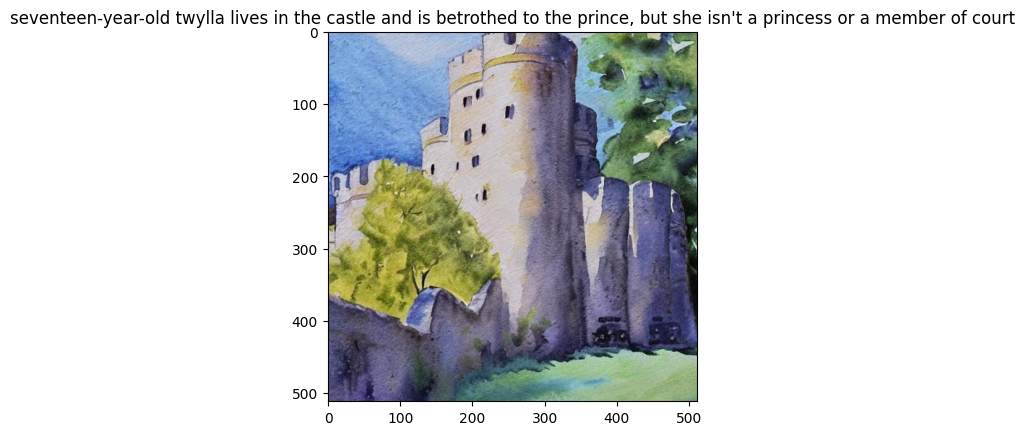

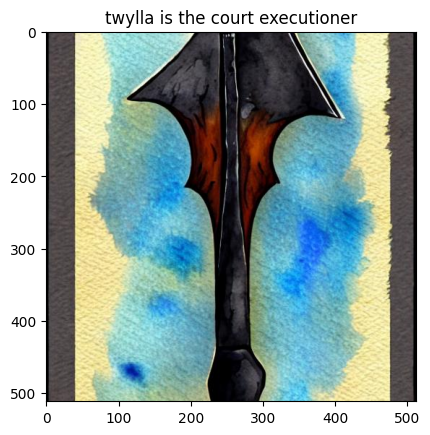

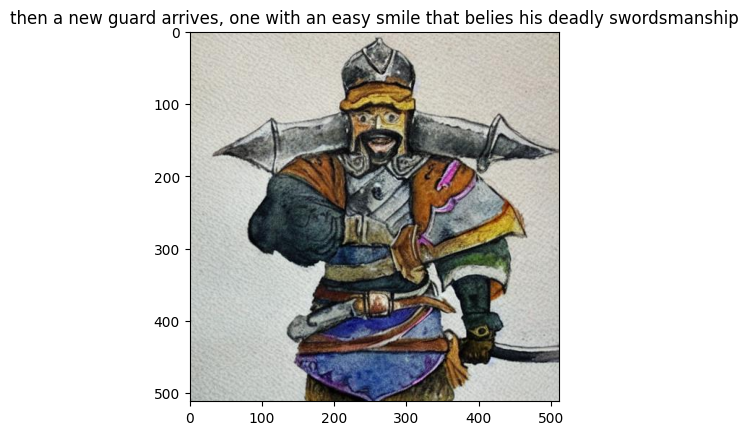

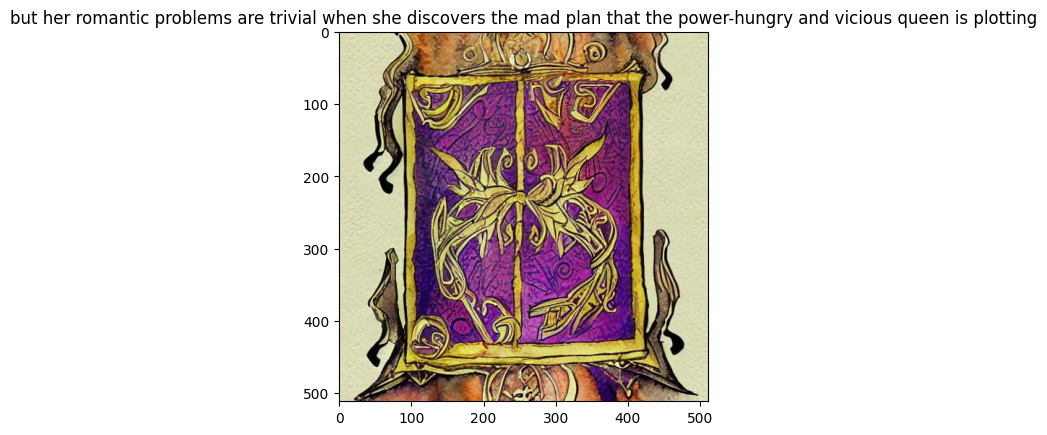

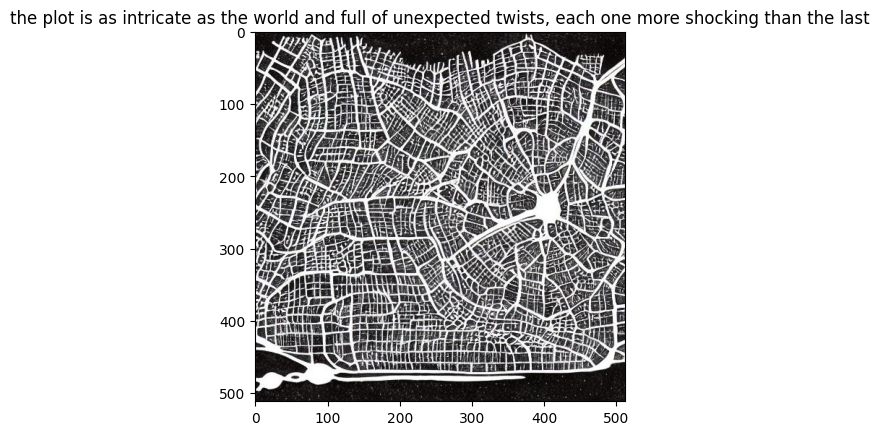

In [9]:
for idx, path in enumerate(c_test['story_13']['image_paths']):
    im = Image.open(path)
    plt.imshow(im)
    plt.title(f"{c_test['story_13']['text'][idx]}")
    plt.show()

In [102]:
for idx, path in enumerate(c_test['story_13']['image_paths']):
    print(f"{c_test['story_13']['text'][idx]}")


seventeen-year-old twylla lives in the castle and is betrothed to the prince, but she isn't a princess or a member of court
twylla is the court executioner
then a new guard arrives, one with an easy smile that belies his deadly swordsmanship
but her romantic problems are trivial when she discovers the mad plan that the power-hungry and vicious queen is plotting
the plot is as intricate as the world and full of unexpected twists, each one more shocking than the last


In [95]:
predict_step(base_model, c_test['story_13']['image_paths'])

We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.
You may ignore this warning if your `pad_token_id` (50256) is identical to the `bos_token_id` (50256), `eos_token_id` (50256), or the `sep_token_id` (None), and your input is not padded.


tensor([[50256,    64, 12036,   286,   257,  2615,   351,   257,  5509,   287,
          2166,   286,   340,   220, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [50256,    64, 12036,   286,   257,  8223,   351,   257,  3272,   319,
           340,   220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [50256,    64, 15207,   286,   257,   582, 12049,   287,   257, 25868,
         16569,   220, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256],
        [50256,    64,  2042,   290,  2330,  4590,   286,   257,  1048,  5762,
           257,  2042,   290,  2330,  1125,    66, 28970, 10147,   290,   257,
          2042,   290,  2330,  1125,    66, 28970,  9839,   220, 50256],
        [50256,    64,  2042,   290,  2330,  4590,   286,   281, 25510,   22

['a painting of a building with a tree in front of it',
 'a painting of a horse with a cross on it',
 'a statue of a man dressed in a pirate costume',
 'a black and white photo of a person wearing a black and white checkered shirt and a black and white checkered tie',
 'a black and white photo of an umbrella']

In [96]:
loadedmodel = VisionEncoderDecoderModel.from_pretrained('./model_epoch1_img_1000/')

In [97]:
loadedmodel.eval()

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [98]:
loadedmodel.to(device)

VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_featur

In [99]:
predict_step(loadedmodel, c_test['story_13']['image_paths'])

tensor([[50256,   732,   389,  2045,   379,   281,  1468,  4590,   286,   262,
          1748,   764,   764,   764, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [50256,   732,   460,   766,   262,  1986,   286,   262,   582,   287,
           262,  4286,   764, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [50256,  1169,   582,   318, 12049,   510,   287,   257, 16569,   764,
           764,   764,   764,   764, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256],
        [50256,   732,   389,  2045,   379,   281,  1468,  6977,  4590,   286,
           257,   582,   287,   257,  2042,   290,  2330, 16313,   764,   764,
           764, 50256],
        [50256,   732,   460,   766,   326,   612,   373,   257,  1256,   286,
          3404,   319,   262,  3084,   764,   764,   764, 50256, 50256, 50256,
         50256, 50256]], device='cuda:0')


['we are looking at an old photo of the city...',
 'we can see the face of the man in the picture.',
 'the man is dressed up in a costume.....',
 'we are looking at an old fashion photo of a man in a black and white outfit...',
 'we can see that there was a lot of stuff on the table...']